In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection')

In [ ]:
PATH= '/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection/Data/'

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalMaxPool1D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from decimal import Decimal
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 33.5 MB/s 
     |████████████████████████████████| 7.6 MB 55.4 MB/s 
     |████████████████████████████████| 163 kB 72.8 MB/s 


In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection/Data/train.csv')
test = pd.read_csv('/content/drive/Shareddrives/ProgettoHLT/FakeNewsDetection/Data/test.csv')

# BERT

In [ ]:
from transformers import AutoTokenizer

SEQ_LEN = 317  # we will cut/pad our sequences to a length of 317 tokens

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# initialize two arrays for input tensors
Xids = np.zeros((len(train['text']), SEQ_LEN))
Xmask = np.zeros((len(train['text']), SEQ_LEN))

for i, sentence in enumerate(train['text']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

labels= train['label'] 

In [ ]:
BATCH_SIZE = 128  # we will use batches of 128

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# batch data
dataset = dataset.batch(BATCH_SIZE) 
train=dataset

In [ ]:
XidsTest = np.zeros((len(test['text']), SEQ_LEN))
XmaskTest = np.zeros((len(test['text']), SEQ_LEN))

for i, sentence in enumerate(test['text']):
    XidsTest[i, :], XmaskTest[i, :] = tokenize(sentence)

labelsT= test['label']

dataset = tf.data.Dataset.from_tensor_slices((XidsTest, XmaskTest, labelsT))
dataset = dataset.map(map_func)
dataset = dataset.batch(BATCH_SIZE)
test = dataset

del dataset  # delete dataset to free up disk-space

# Best Model

In [ ]:
from transformers import TFAutoModel

# initialize uncased BERT model
bert = TFAutoModel.from_pretrained('bert-base-uncased')

input_ids = Input(shape=(317,), name='input_ids', dtype='int32')
mask = Input(shape=(317,), name='attention_mask', dtype='int32')

# we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
embeddings = bert(input_ids, attention_mask=mask)[0]

X = Bidirectional(LSTM(64, return_sequences= True))(embeddings)
X = GlobalMaxPool1D()(X)
X = Dropout(0.3)(X)

X = Dense(32, activation='relu')(X)
y = Dense(1, activation='sigmoid', name='outputs')(X)

# define input and output layers of our model
best_model = Model(inputs=[input_ids, mask], outputs=y)

# freeze the BERT layer - otherwise we will be training 100M+ parameters...
best_model.layers[2].trainable = False

best_model.compile(optimizer=Adam(lr=0.0005, clipnorm=3), loss="binary_crossentropy", metrics=['accuracy'])

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 317)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 317)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 317,                                           

# Best Model Retraining on full dataset

In [ ]:
# Train loss achieved with Model Selection
train_thold= 0.0102

In [ ]:
# Stopping criterion (Retrain until the loss is above the threshold)

class SOMT(Callback):

    def __init__(self, model,  train_thold):
        super(SOMT, self).__init__()
        self.model=model        
        self.train_thold=train_thold
        
    def on_epoch_end(self,epoch, logs={}): 
        tr_loss=logs.get('loss')
        if tr_loss <= self.train_thold:
            self.model.stop_training = True # stop training
            print( f'\nTraining stopped because loss reached the threshold')

In [ ]:
# Retraining Best Model
es = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
history = best_model.fit(train, batch_size=BATCH_SIZE, epochs=30, callbacks=[es, SOMT(best_model, train_thold)]) 

Epoch 1/30
131/131 [==============================] - 443s 3s/step - loss: 0.3539 - accuracy: 0.8352
Epoch 2/30
131/131 [==============================] - 425s 3s/step - loss: 0.1889 - accuracy: 0.9318
Epoch 3/30
131/131 [==============================] - 424s 3s/step - loss: 0.1231 - accuracy: 0.9551
Epoch 4/30
131/131 [==============================] - 424s 3s/step - loss: 0.0974 - accuracy: 0.9644
Epoch 5/30
131/131 [==============================] - 424s 3s/step - loss: 0.0818 - accuracy: 0.9698
Epoch 6/30
131/131 [==============================] - 424s 3s/step - loss: 0.0666 - accuracy: 0.9778
Epoch 7/30
131/131 [==============================] - 424s 3s/step - loss: 0.0606 - accuracy: 0.9793
Epoch 8/30
131/131 [==============================] - 424s 3s/step - loss: 0.0526 - accuracy: 0.9816
Epoch 9/30
131/131 [==============================] - 424s 3s/step - loss: 0.0468 - accuracy: 0.9831
Epoch 10/30
131/131 [==============================] - 424s 3s/step - loss: 0.0388 - accura

In [ ]:
# if the loss did not reach the threshold
if len(history.history["loss"])==30:
  best_ep = np.argmin(history.history["loss"])+1 
else:
  best_ep = np.argmin(history.history["loss"][:-1])+1 

In [ ]:
print("Model stopped at epoch", best_ep)

Model stopped at epoch 20


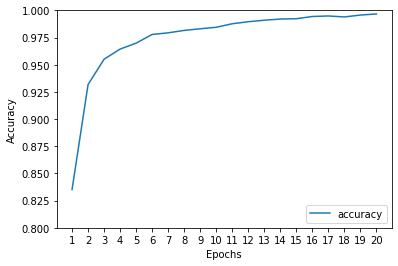

In [ ]:
#Accuracy plot
plt.plot(history.history["accuracy"][0:best_ep], label='accuracy')       
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.8,1])
plt.xticks(np.arange(len(history.history["accuracy"][0:best_ep])), np.arange(1, len(history.history["accuracy"][0:best_ep])+1))
plt.legend(loc = 'lower right')

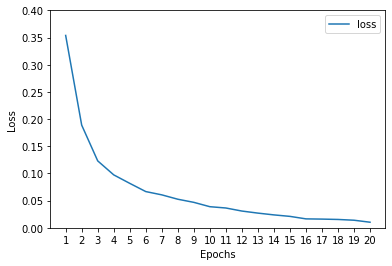

In [ ]:
#Loss plot
plt.plot(history.history["loss"][0:best_ep], label='loss')       
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,0.4])
plt.xticks(np.arange(len(history.history["loss"][0:best_ep])), np.arange(1, len(history.history["loss"][0:best_ep])+1))
plt.legend(loc = 'upper right')

# Best Model Performance on Test Set


## Classification Threshold 0.50

In [ ]:
pred = best_model.predict(test) > 0.5

32/32 [==============================] - 95s 3s/step


In [ ]:
# Getting the Classification Report
print(classification_report(list(labelsT), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9864    0.9909    0.9887      1979
           1     0.9912    0.9869    0.9890      2056

    accuracy                         0.9888      4035
   macro avg     0.9888    0.9889    0.9888      4035
weighted avg     0.9889    0.9888    0.9888      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(labelsT), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.88 %


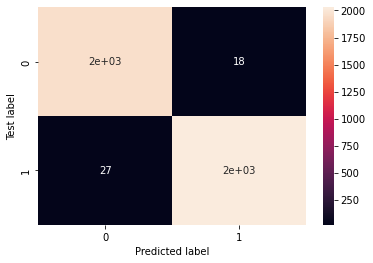

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting The Confusion Matrix
cm = confusion_matrix(list(labelsT), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

# Best Model Performance on Test Set with different Classification Thresholds

## Classification Threshold 0.80

In [ ]:
pred = (best_model.predict(test) > 0.8)

32/32 [==============================] - 91s 3s/step


In [ ]:
# Getting the Classification Report
print(classification_report(list(labelsT), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9781    0.9944    0.9862      1979
           1     0.9946    0.9786    0.9865      2056

    accuracy                         0.9864      4035
   macro avg     0.9863    0.9865    0.9864      4035
weighted avg     0.9865    0.9864    0.9864      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(labelsT), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.64 %


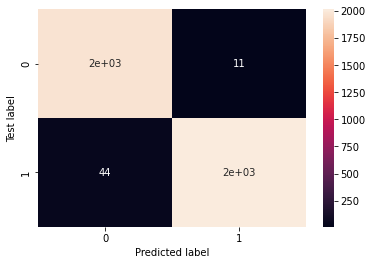

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(labelsT), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.90

In [ ]:
pred = (best_model.predict(test) > 0.9)

32/32 [==============================] - 91s 3s/step


In [ ]:
# Getting the Classification Report
print(classification_report(list(labelsT), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9757    0.9949    0.9852      1979
           1     0.9950    0.9762    0.9855      2056

    accuracy                         0.9854      4035
   macro avg     0.9854    0.9856    0.9854      4035
weighted avg     0.9856    0.9854    0.9854      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(labelsT), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.54 %


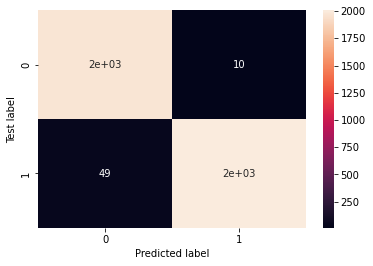

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(labelsT), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.95

In [ ]:
pred = (best_model.predict(test) > 0.95)

32/32 [==============================] - 91s 3s/step


In [ ]:
# Getting the Classification Report
print(classification_report(list(labelsT), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9695    0.9965    0.9828      1979
           1     0.9965    0.9698    0.9830      2056

    accuracy                         0.9829      4035
   macro avg     0.9830    0.9832    0.9829      4035
weighted avg     0.9833    0.9829    0.9829      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(labelsT), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  98.29 %


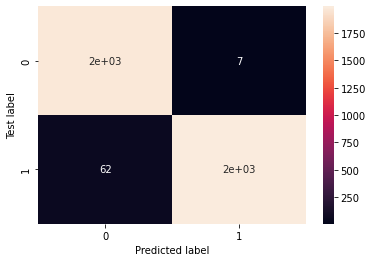

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(labelsT), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()

## Classification Threshold 0.99

In [ ]:
pred = (best_model.predict(test) > 0.99)

32/32 [==============================] - 91s 3s/step


In [ ]:
# Getting the Classification Report
print(classification_report(list(labelsT), pred, digits=4))

              precision    recall  f1-score   support

           0     0.9597    0.9985    0.9787      1979
           1     0.9985    0.9596    0.9787      2056

    accuracy                         0.9787      4035
   macro avg     0.9791    0.9791    0.9787      4035
weighted avg     0.9795    0.9787    0.9787      4035



In [ ]:
# Getting the Test Accuracy
accuracy = accuracy_score(list(labelsT), pred)
print("Test Accuracy : ", round(Decimal(accuracy*100),2),"%")

Test Accuracy :  97.87 %


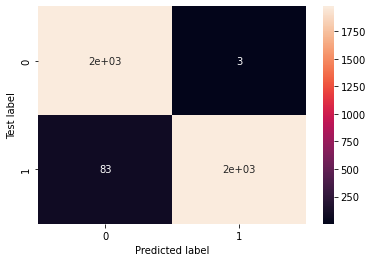

<Figure size 720x720 with 0 Axes>

In [ ]:
# Getting the Confusion Matrix
cm = confusion_matrix(list(labelsT), pred)
sns.heatmap(cm, annot = True)
plt.ylabel('Test label')
plt.xlabel('Predicted label')
plt.figure(figsize = (10, 10))
plt.show()